In [26]:
from dolfin import *
from IPython.display import HTML
import matplotlib.pyplot as plt
import mshr as mh
import time
from math import floor
%matplotlib inline

La ecuación que trabajaremos será la ecuación del calor en medio isotrópico no homogéneo

$$u_t - \kappa(x)A(x)\nabla u = f_e(x)$$

Donde

* $u(x,t)$ es la temperatura

* $f_e(x)$ representa una fuente o fuentes de calor (estufas).

* $\kappa(x) = \dfrac{1}{\rho c_e}$ es la inversa (multiplicativa) del calor específico, multiplicado por la densidad, del medio en $x$. Se asumirá constante por pedazos (los medios que trabajaremos serán aire y paredes principalmente).

* $A(x)$ es la conductividad térmica del medio en $x$. Al asumir un medio isotrópico (cuya conductividad no depende de la dirección) es una matriz diagonal. También la asumimos constante por pedazos (de no serlo, ese término sería $\kappa(x) \sum_{i,j} \partial_{x_i} (A(x)\partial_{x_j}u)$)

Usaremos diferentes condiciones de borde. Podemos asumir, por ejemplo, condiciones de borde de tipo Dirichlet (temperatura exterior constante), condiciones de borde de tipo Neumann (para modelar el hecho de que hay temperatura que sale al exterior), o bien una condición mixta.


En primer lugar, se trabajará el problema simplificado a una habitación. Posteriormente, se extenderá a una casa en 2D.

In [27]:
''' #### EN ESTE Y EL SIG. BLOQUE se resuelve el caso simplificado ####
Los parámetros a definir serán:
la discretización temporal (número de pasos),
la temperatura exterior,
la temperatura y posición de la estufa,
las áreas que son paredes,
el calor específico y conductividad térmica de cada medio (aire, pared)
'''
#Parámetros experimento 1 (habitación cerrada, cuadrada)
T = 1800 # Tiempo final (segundos)
número_pasos = 300
temperatura_exterior = 10.
temperatura_estufa = 600.
x_estufa = 2/7 #posición de la estufa
y_estufa = 5/7
#Booleano que, en C++, evalúa que un punto esté dentro de alguna pared (después probablemente lo haré con clases) 
en_paredes = "(x[0]<=1/7 || x[0]>= 6/7 || x[1]<=1/7 || x[1]>= 6/7)"
#Calores específicos, densidades y conductividades térmicas de ambos medios (pared y aire)
#(Los asumiremos constantes, en realidad cambian con la temperatura y presión: esto será importante en el caso 3D)
cal_esp_p = 0.76
rho_p = 450 #asumimos pared de madera
cond_p = 0.1

cal_esp_a = 1.01
rho_a = 1.24
cond_a = 0.02

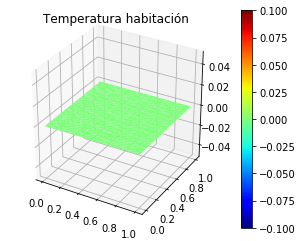

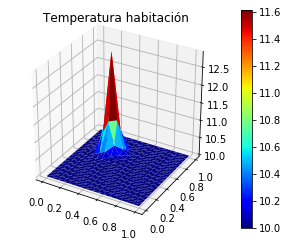

Tiempo: 6.00, solución guardada con norma L2 10.043045


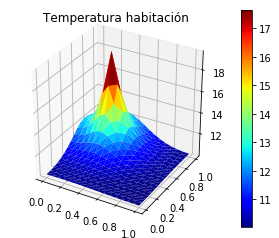

Tiempo: 186.00, solución guardada con norma L2 11.371750


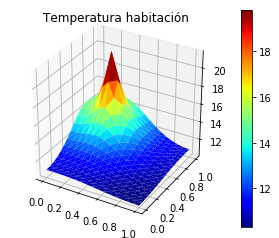

Tiempo: 366.00, solución guardada con norma L2 12.673335


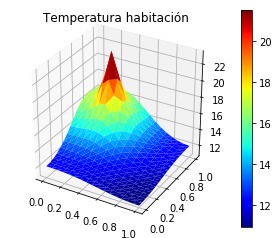

Tiempo: 546.00, solución guardada con norma L2 13.945367


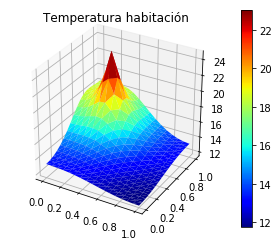

Tiempo: 726.00, solución guardada con norma L2 15.195099


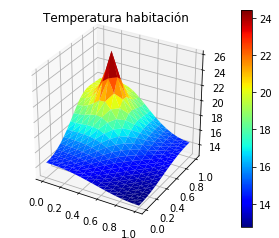

Tiempo: 906.00, solución guardada con norma L2 16.431397


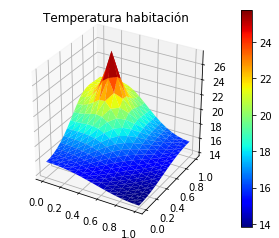

Tiempo: 1086.00, solución guardada con norma L2 17.660487


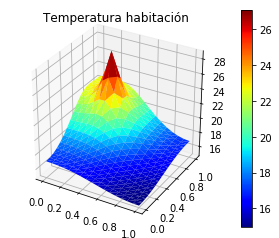

Tiempo: 1266.00, solución guardada con norma L2 18.886111


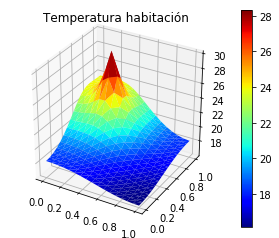

Tiempo: 1446.00, solución guardada con norma L2 20.110358


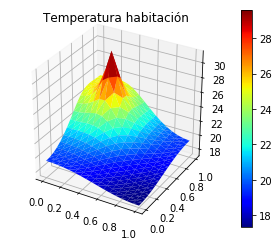

Tiempo: 1626.00, solución guardada con norma L2 21.334330
Iteración terminada


In [29]:

# Paso de tiempo
Δt = T / número_pasos

# Crear malla y si es necesario, refinar cerca de la estufa
malla = UnitSquareMesh(16,16)
"""malla = UnitSquareMesh(16,16)
subdom = MeshFunction("bool", malla, 2)
subdom.set_all(False)
circulito = 'pow(x[0] - x_0, 2) + pow(x[1] - x_1, 2) <= pow(r, 2)'
subdomain = CompiledSubDomain(circulito, x_0 = x_estufa,x_1 = y_estufa,r = 0.1)
subdomain.mark(subdom, True)
malla = refine(malla, subdom)"""
# Espacio de funciones a considerar
V = FunctionSpace(malla,'Lagrange', 1)

##Funciones
#algunas variables auxiliares
eps = 0.04
en_aire = "!"+en_paredes  #el aire es el espacio que queda

#Función de la fuente
f = Expression("t_e*exp(-(pow(x[0] - x_e, 2) + pow(x[1] - y_e, 2))/reg)", degree = 1,
               x_e = x_estufa, y_e = y_estufa,
               t_e = temperatura_estufa, reg = eps)

en_estufa = "(pow(x[0]-%s,2) + pow(x[1] - %s, 2) <= pow(%s, 2))" %(str(x_estufa), str(y_estufa), str(eps))
f = Expression("t_e*%s"%en_estufa, degree = 1, t_e = temperatura_estufa)
#cpp_f = "%s*%s - 10*(x[0] < 0.03 && x[1] > 2/3 && x[1] < 2/3)"%(temperatura_estufa,en_estufa)
#f = Expression(cpp_f, degree = 1)
#Función de conductividad térmica
K = Expression("k_pared*"+en_paredes+" + k_aire*"+en_aire, degree=1,
              k_pared = cond_p, k_aire  = cond_a)
#Función de calor específico (junto con la densidad)
ρC = Expression("d_pared*C_pared*"+en_paredes+" + d_aire*C_aire*"+en_aire, degree = 1,
                d_pared = rho_p, C_pared = cal_esp_p,
                d_aire  = rho_a,  C_aire = cal_esp_a)
# Condiciones de borde
#Borde Dirichlet
cpp_borde = "(x[0] < DOLFIN_EPS || x[0] > 1. - DOLFIN_EPS || x[1] < DOLFIN_EPS || x[1] > 1. - DOLFIN_EPS ) && on_boundary"
cpp_borde = "x[0] < DOLFIN_EPS && x[1]>1/3 && x[1] < 2/3 && on_boundary"
bc = DirichletBC(V, Constant(temperatura_exterior), cpp_borde)

#Borde Neumann (consideraremos que no varía en los bordes: más adelante, variará según la temperatura de afuera)
g = Expression("0.", degree = 1)

#Funciones para la formulación variacional
u, v = TrialFunction(V), TestFunction(V)
u_n = Function(V)

##Formulación variacional y sistema lineal
F = u*v*dx + Δt*inner(grad(u), grad(v))*(K/ρC)*dx - (u_n + Δt*f/ρC)*v*dx - Δt*g*v*ds
a, L = lhs(F), rhs(F)

# Preparación para guardar la solución
archivo_sol = File('Resultados/calor.pvd')
sols = []

# Iteración principal
u = Function(V)
u_n.assign(Expression(str(temperatura_exterior), degree = 1))
fig = plt.figure()
p = plot(u, title="Temperatura habitación", mode="warp")
fig.colorbar(p)
plt.show()
t = 0
for n in range(número_pasos):
    # Update-time
    t += Δt
    # Solve linear system
    solve(a == L, u, bc)
    
    # Save results
    archivo_sol << (u, t)
    
    if n % floor(número_pasos/10) == 0:
        fig = plt.figure()
        p = plot(u, title="Temperatura habitación", mode="warp")
        fig.colorbar(p)
        plt.show()
        print("Tiempo: {:.2f}, solución guardada con norma L2 {:4f}".format(t,norm(u, "L2")))
    # Update solution at time n and save to list for plotting
    u_n.assign(u)
    sols.append(u.copy(deepcopy=True))

print("Iteración terminada")

In [23]:
"""ESTE BLOQUE DEFINE, para el caso general, las clases y funciones necesarias para construir el mallado
y entregar los parámetros del problema"""

class InitError(Exception):
    pass

# Clase madre para las estructuras
class rect:
    def __init__(s,args):
        if len(args)==2: #opción 1: pasarle 2 puntos e.g. rect( [[0,0], [1,3]] )
            s.p1 = args[0]
            s.p2 = args[1]
            s.hor = abs(s.p2[0]-s.p1[0])
            s.ver = abs(s.p2[1]-s.p1[1])
        elif len(args) == 3: #opción 2: pasarle un punto, largo horizontal y largo vertical e.g. rect( [[0,0],1,3] )
            s.p1, s.hor, s.ver = args
            s.p2 = [s.p1[0]+s.hor , s.p1[1]+s.ver]
        else: raise InitError("Rectángulo no correctamente inicializado")

#pared es un rectángulo con ciertas propiedades físicas
class pared(rect):
    def __init__(s,geom, prop = [0.76, 450, 0.1]): #coords es la info geométrica de la pared; props son las propiedades físicas
        rect.__init__(s,geom)#heredar todos los atributos de rect: p1,p2,hor,ver
        s.cal_esp = prop[0]
        s.rho = prop[1]
        s.cond = prop[2]
        s.tipo = "interna"
        
    def cpp(s, x = 'x[0]', y = 'x[1]'): 
        #Entrega string de la función booleana que evalúa si el punto P está en la pared. El punto P los strings
        #con que se van a representar las coordenadas del punto en la función
        x1,y1 = (str(c) for c in s.p1)
        x2,y2 = (str(c) for c in s.p2)
        b = "(%s >= %s && %s <= %s && %s >= %s && %s <= %s)" % (x,x1,x,x2,y,y1,y,y2)
        return b
    
    def cpp_b(s,x = 'x[0]', y = 'x[1]', eps = 0.1):
        #Análogo a pared.cpp() que entrega parametrización de la región eps unidades de longitud a cada lado de cada borde,
        #para refinar la malla
        x1,y1 = (str(c) for c in s.p1)
        x2, y2 = (str(c) for c in s.p2)
        b = "((%s>= %s && %s <= %s && (abs(%s-%s) <=%s || abs(%s-%s) <= %s)) || (%s>= %s && %s <= %s && (abs(%s-%s) <=%s || abs(%s-%s) <= %s)) )" % (x,x1,x,x2,y,y1,eps,y,y2,eps,
                                                                                                                                                    y,y1,y,y2,x,x1,eps,x,x2,eps)
        return b                                                                                                                                
    
class pared_ext(pared):
    def __init__(s,geom, direcc, prop = [0.76, 450, 0.1]):
        pared.__init__(s,geom,prop)
        s.dir = direcc #puede ser "N", "O", "S", "E" e indica la dirección en la que es exterior (para el borde)
        s.tipo = "externa"
        
    def cpp_bext(s,x = 'x[0]', y = 'x[1]',eps = "DOLFIN_EPS"):
        #String de la función booleana que evalúa si se está en el borde de la casa.
        x1, y1 = (str(c) for c in s.p1)
        x2, y2 = (str(c) for c in s.p2)
        if s.dir == "N":
            b = "(%s >= %s && %s <= %s && %s <= %s && %s > %s - %s)" % (x,x1,x,x2, y,y2, y,y2,eps)
        elif s.dir == "O":
            b = "(%s >= %s && %s <= %s && %s >= %s && %s < %s + %s)" % (y,y1,y,y2, x,x1, x,x1,eps)
        elif s.dir == "S":
            b = "(%s >= %s && %s <= %s && %s >= %s && %s < %s + %s)" % (x,x1,x,x2, y,y1, y,y1,eps)
        elif s.dir == "E":
            b = "(%s >= %s && %s <= %s && %s <= %s && %s > %s - %s)" % (y,y1,y,y2, x,x2, x,x2,eps)
        else: raise InitError("Dirección de la pared debe ser una de las cuatro: N, O, S, E")
        return b
    def cpp_b(s,x = 'x[0]', y = 'x[1]', eps = 0.1): #modifica cpp_b para que entrege solo la región opuesta a la de afuera
        x1, y1 = (str(c) for c in s.p1) #A esta altura me doy cuenta que podía evitar el str() usando %f después, pero eso podría
        x2, y2 = (str(c) for c in s.p2) #                                                      traer bugs si se ingresan enteros
        if s.dir =="N":
            b = "(%s >= %s && %s <= %s && abs(%s - %s) <= %s)" % (x,x1, x,x2,  y,y1,eps)
        elif s.dir == "O":
            b = "(%s >= %s && %s <= %s && abs(%s - %s) <= %s)" % (y,y1, y,y2,  x,x2,eps)
        elif s.dir == "S":
            b = "(%s >= %s && %s <= %s && abs(%s - %s) <= %s)" % (x,x1, x,x2,  y,y2,eps)
        elif s.dir == "E":
            b = "(%s >= %s && %s <= %s && abs(%s - %s) <= %s)" % (y,y1, y,y2,  x,x1,eps)
        else: raise InitError("Dirección de la pared debe ser una de las cuatro: N, O, S, E")
        return b
    
class estufa:
    def __init__(s, P, t= 600, r = 0.1):
        s.p = P #coordenadas de la estufa
        s.t = t #temperatura de la estufa
        s.r = r
        
    def cpp_c(s, x = "x[0]", y = "x[1]",r = None):
        """expresión en C++ que evalúa si se está dentro del 'círculo importante' de la estufa, para refinamiento.
        """
        if r == None: r = s.r
        xe,ye = (str(c) for c in s.p)
        r = str(r)
        b = "( pow(%s - %s,2) + pow(%s - %s,2) <= pow(%s, 2) )" % (x,xe,  y,ye,  r)
        return b

    def fun(s,eps, x = "x[0]", y = "x[1]"):
        xe, ye = (str(c)for c in s.p)
        te = str(s.t)
        f = "%s * %s" % (te,s.cpp_c(r = eps))
        return f
    
class aire(pared):
    def __init__(s,geom, prop = [1.01, 1.24, 0.02]):
        pared.__init__(s,geom,prop)
        s.tipo = "aire"
    def cpp_b(s):
        return "" #el aire no necesita refinamiento
    
class abertura(pared_ext):
    def __init__(s,geom,direcc,prop = [1.01, 1.24, 0.02]):
        pared.__init__(s,geom,prop)
        s.tipo = "abertura"
        s.dir = direcc
    def cpp_b(s):
        return ""
    
from mshr import Rectangle, Circle, generate_mesh
from dolfin import Point, MeshFunction, CompiledSubDomain, X3DOM, refine
from IPython.display import HTML
    
class Casa: #Construye el dominio del problema a partir de los bloques dados
    def __init__(s, paredes, estufas):
        #Observación! las paredes pueden tener distintos atributos físicos, por lo que el orden de las paredes importará
        #(ya que se pueden sobreponer entre sí). Una solución sólida sería programar la diferencia de rectángulos, ya que éstos
        #forman una subálgebra. La estrategia actual es asumiir que el usuario ingresa las paredes en el orden apropiado.
        s.pars = paredes
        s.ests = estufas
        s.malla = None
        enp = "(0 "
        for par in s.pars:
            if par.tipo != "aire" and par.tipo != "abertura":
                enp = enp + "||"+ par.cpp()
        s.en_paredes = enp + ")"
        s.en_aire = "!"+s.en_paredes
        #Encontrar props de la casa, porque falta el código para hacera con materiales heterogéneos
        s.cal_esp = None; s.rho = None; s.cond = None;
        s.cal_espa = None; s.rhoa = None; s.conda = None;
        for par in s.pars:
            if par.tipo == "externa" or par.tipo =="interna":
                s.cal_esp = par.cal_esp
                s.rho = par.rho
                s.cond = par.cond
                break
        for par in s.pars:
            if par.tipo == "aire" or par.tipo == "abertura":
                s.cal_espa = par.cal_esp
                s.rhoa = par.rho
                s.conda = par.cond
                break
        
    def mallar(s, ver = True): #Aquí se crea el mallado de la casa, en orden (puede tomar cierto tiempo)
        #paredes, luego estufas
        # muestra la malla si ver es True (por defecto es True)
        par = s.pars[0]
        x1,y1 = par.p1; x2,y2 = par.p2
        figura_actual = Rectangle(Point(x1,y1),Point(x2,y2))
        for par in s.pars[1:]:
            x1,y1 = par.p1; x2,y2 = par.p2
            figura_actual = figura_actual + Rectangle(Point(x1,y1),Point(x2,y2))
        for est in s.ests:
            xe, ye = est.p
            figura_actual = figura_actual + Circle(Point(xe,ye), est.r)
        mesh = generate_mesh(figura_actual,40)
        
        subdoms = MeshFunction("bool", mesh, 2)
        subdoms.set_all(False)
    
        for par in s.pars:#iterar sobre todas las paredes
            if not par.tipo in ["aire", "abertura"]: #si es aire o abertura, se lo salta
                subdomaux = CompiledSubDomain(par.cpp_b())
                subdomaux.mark(subdoms, True)
    
        for est in s.ests:
            subdomaux = CompiledSubDomain(est.cpp_c())
            subdomaux.mark(subdoms, True)
        mesh = refine(mesh, subdoms)
        s.malla = mesh
        if ver:
            HTML(X3DOM.html(mesh))
        return mesh
        
    def K(s):
        c = str(s.cond); c_a = str(s.conda)
        b = "%s * %s + %s * %s" % (c, s.en_paredes, c_a, s.en_aire)
        return b
      
    def rhocal(s):
        P = str(s.rho*s.cal_esp)
        A = str(s.rhoa*s.cal_espa)
        b = "%s * %s + %s * %s" % (P, s.en_paredes, A, s.en_aire)
        return b

    def dirichlet(s): #entrega string de c++ equivalente al borde Dirichlet, que será donde hay aire en las 
        #paredes externas
        b= "on_boundary && (0 "
        for pared in s.pars:
            if pared.tipo == "abertura" or pared.tipo == "externa": #solo para las aberturas es Dirichlet!
                b = b + ( " || %s" %(pared.cpp_bext()) )
        b+= ")"
        return b
    #######################################################################################################################
    def simular(s, T=1800, número_pasos = 300, temperatura_exterior = 4):
        malla = s.malla
        Δt = T / número_pasos
        V = FunctionSpace(malla,'Lagrange', 1)
        eps = 0.03
        #Función de la fuente
        cpp_f = ""
        for est in s.ests:
            cpp_f += " + "+est.fun(eps)
        
        f = Expression(cpp_f, degree = 1)
        
        #Función de conductividad térmica
        K = Expression(s.K(), degree=1)
        
        #Función de calor específico (junto con la densidad)
        ρC = Expression(s.rhocal(), degree = 1)
        
        # Condiciones de borde
        #Borde Dirichlet
        bc = DirichletBC(V, Constant(temperatura_exterior), s.dirichlet())

        #Borde Neumann
        g = Expression("0.", degree = 1)

        #Funciones para la formulación variacional
        u, v = TrialFunction(V), TestFunction(V)
        u_n = Function(V)

        ##Formulación variacional y sistema lineal
        F = u*v*dx + Δt*inner(grad(u), grad(v))*(K/ρC)*dx - (u_n + Δt*f/ρC)*v*dx - Δt*g*v*ds
        a, L = lhs(F), rhs(F)

        # Preparación para guardar la solución
        archivo_sol = File('Resultados/calor.pvd')
        sols = []

        # Iteración principal
        u = Function(V)
        u_n.assign(Expression(str(temperatura_exterior), degree = 1))
        
        fig = plt.figure()
        p = plot(u, title="Temperatura habitación", mode="warp")
        fig.colorbar(p)
        plt.show()
        clear_output(wait = True)
        t = 0
        for n in range(número_pasos):
            # Update-time
            t += Δt
            # Solve linear system
            solve(a == L, u, bc)

            # Save results
            archivo_sol << (u, t)

            if n % floor(número_pasos/10) == 0:
                
                fig = plt.figure()
                p = plot(u, title = "Temperatura habitación", mode="warp")
                fig.colorbar(p)
                plt.show()
                print("Tiempo: {:.2f}, solución guardada con norma L2 {:4f}".format(t,norm(u, "L2")))
                clear_output(wait = True)
            # Update solution at time n and save to list for plotting
            u_n.assign(u)
            sols.append(u.copy(deepcopy=True))
    
    
    
    

In [24]:
"""Test
  _____B____ a _C_
  |              |
A | .         b__|
  |____   ____   |D
       G      | .|
             F|__|
                E
"""
A = pared_ext([[0,0],0.3,3], "O")
B = pared_ext([[0.3,2.7],3,0.3], "N")
a = abertura([[3.3,2.7],1,0.3],"N")
C = pared_ext([[4.3,2.7],1,0.3], "N")
D = pared_ext([[5.3,-1],[5.6,3]],"E")
E = pared_ext([[4.3,-1],[4.7,0.7]],"E")
F = pared_ext([[4,-1],[4.3,0]],"O")
G1 = pared_ext([[0.3,0],[2.3,0.3]],"S")
G2 = pared_ext([[3.3,0],[4.3,0.3]],"S")
c = abertura([[2.3, 0], [3.3,0.3]],"S")
b = pared([[4.3,1.5],1,0.3])
a2 = aire([[0,0],[5.7,3]])
a3 = aire([[4.3,-1],[5.7,3]])
paredes = [a2,a3,a,c,A,B,C,D,E,F,G1,G2,b]
est1 = estufa([1,1])
est2 = estufa([4.9,-0.4])

casa = Casa(paredes, [est1,est2])
casa.mallar(ver = True)
print("Mallado listo!")
#casa.simular()

Mallado listo!


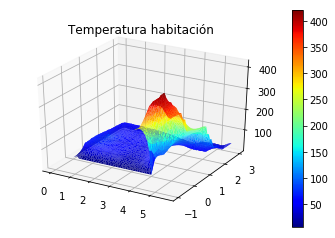

Tiempo: 1626.00, solución guardada con norma L2 569.361712


In [30]:
from IPython.display import clear_output
casa.simular()